<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/tf_cnn_lstm9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
We have to deal with overfitting and underfitting explicitly
So lets say that we apply regularization for solving overfitting and make the model more complex for solving underfiiting
'''

'\nWe have to deal with overfitting and underfitting explicitly\nSo lets say that we apply regularization for solving overfitting and make the model more complex for solving underfiiting\n'

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.22.39.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.22.39.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.39.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
X=np.load("/content/gdrive/MyDrive/hand sign database array X.npy")
Y=np.load("/content/gdrive/MyDrive/hand sign database array Y.npy")

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfKL
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd

nLookback=4
height=50
width=50
channels=3
nCategories=8

In [5]:
def sameLists(l1,l2):
  i=0
  for li1 in l1:
    j=0
    for li2 in li1:
      change=l1[i][j]-l2[i][j]
      answer=np.count_nonzero(change)
      if answer>0:
        return False
      j+=1
    i+=1
  return True

In [11]:
def createModel(dropoutsRates=list((0.5,0.5,0.5,0.5)),nLSTMunits=(100,100)):
  with tpu_strategy.scope():
    model=tf.keras.Sequential()
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True),input_shape=(None,nLookback,height,width,channels)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[0],trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[1],trainable=True)))

    model.add(tfKL.TimeDistributed(tfKL.MaxPooling3D(pool_size=(2,2,2),trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Flatten(trainable=True)))


    model.add(tfKL.LSTM(units=nLSTMunits[0],activation='tanh',trainable=True,return_sequences=True))
    model.add(tfKL.Dropout(dropoutsRates[2],trainable=True))


    model.add(tfKL.LSTM(units=nLSTMunits[1],activation='tanh',trainable=True))
    model.add(tfKL.Dropout(dropoutsRates[3],trainable=True))

    model.add(tfKL.Dense(units=100,activation='relu',trainable=True))
    model.add(tfKL.Dense(units=nCategories,activation='softmax',trainable=True))
    model.compile(metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam')
    return model

In [12]:
def evaluateModel(X,Y,nSubsequences=5,nLookback=4,nCategories=8,train_size=0.8,verbose=0,epochs=30,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5,0.5)),nLSTMunits=(100,100)):
  with tpu_strategy.scope():
    trainX, testX, trainY, testY = train_test_split(X, Y, train_size=train_size, random_state=random.randint(1,100000))
  
  verbose=verbose
  epochs=epochs
  batch_size=10

  
  height=trainX.shape[2]
  width=trainX.shape[3]
  channels=trainX.shape[4]
  trainX=trainX.reshape((trainX.shape[0],nSubsequences,nLookback,trainX.shape[2],trainX.shape[3],trainX.shape[4]))
  testX=testX.reshape((testX.shape[0],nSubsequences,nLookback,testX.shape[2],testX.shape[3],testX.shape[4]))
  trainY=tf.keras.utils.to_categorical(trainY)
  testY=tf.keras.utils.to_categorical(testY)
  accuracy=0
  model=createModel(dropoutsRates=dropoutsRates,nLSTMunits=nLSTMunits)
  with tpu_strategy.scope():
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_split =val_prop)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    _,accuracy=model.evaluate(testX,testY,verbose=0,batch_size=batch_size)
  return accuracy

In [13]:
def summarizeScores(scores):
  print("Scores: ",scores)
  m,s=np.mean(scores),np.std(scores)
  x=[i for i in range(np.shape(scores)[0])]
  plt.plot(x,scores)
  
  plt.xlabel('Run')
  plt.ylabel('Accuracy')
  
  plt.show()
  print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [14]:
def runExperiments(X,Y,train_size=0.8,run=10,epochs=30,verbose=0,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=200):#weights are changing for each run in experiment we can transfer weights accross experiments too but we are not doing that right now
  scores=list()
  for r in range(run):
    score=evaluateModel(X=X,Y=Y,train_size=train_size,epochs=epochs,val_prop=val_prop,dropoutsRates=dropoutsRates,nLSTMunits=nLSTMunits)
    score*=100.0
    scores.append(score)
    print('>#%d: %.3f' % (r+1, score))
  summarizeScores(scores)
  print("--------------------------------------------------------------------------------------------------------------------------")

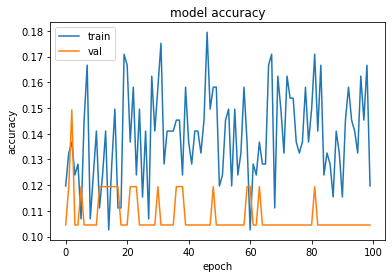

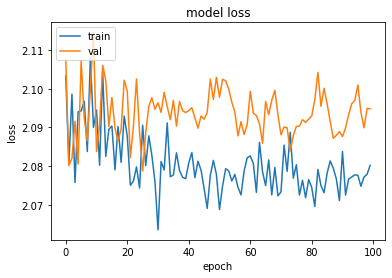

>#1: 9.901


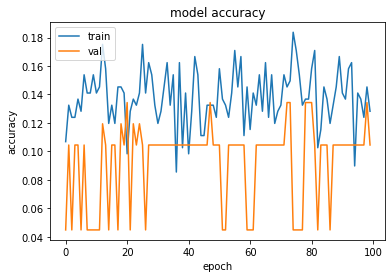

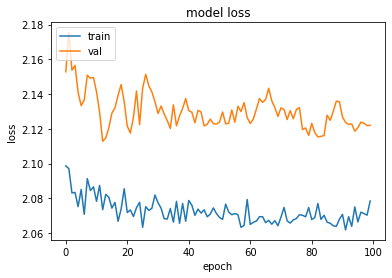

>#2: 9.901


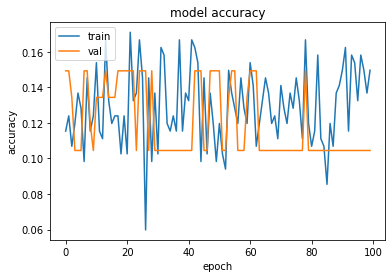

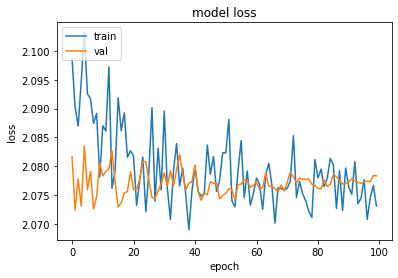

>#3: 11.881


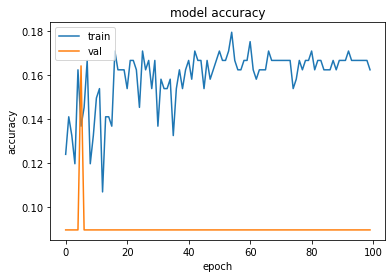

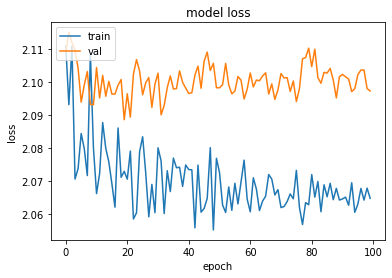

>#4: 6.931


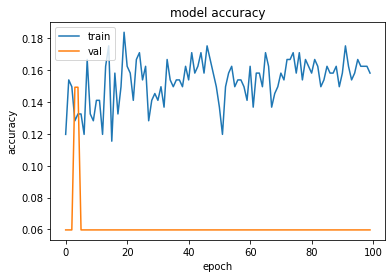

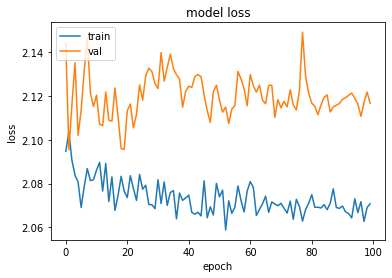

>#5: 9.901
Scores:  [9.90099012851715, 9.90099012851715, 11.881187558174133, 6.9306932389736176, 9.90099012851715]


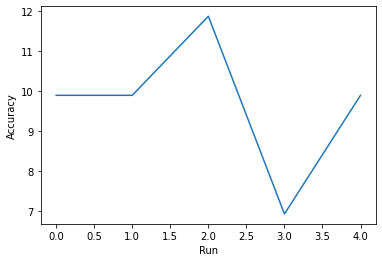

Accuracy: 9.703% (+/-1.584)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [15]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.5,0.5,0.5,0.5)),nLSTMunits=(100,100))
  print("-------------------------------------------")

In [ ]:
'''
clearly we can see that adding a new lstm layer has increased the model complexity and has reduced the problem of training curve starting above the validation curve
But now what we see is that the gap between the train and val curve has increased much more
One more thing we can see is that the model now performs better on the train set but it seems that the performance on the validation set has 
become poor
'''

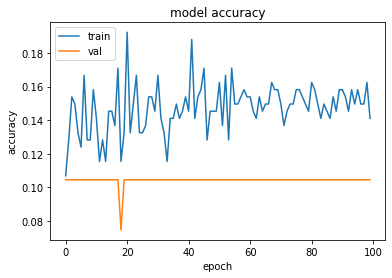

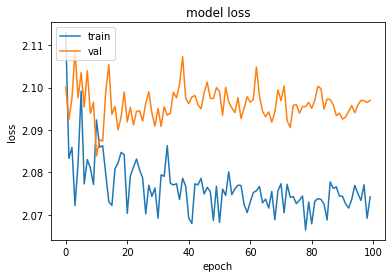

>#1: 8.911


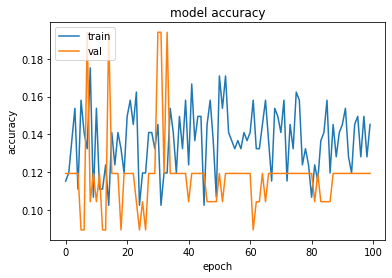

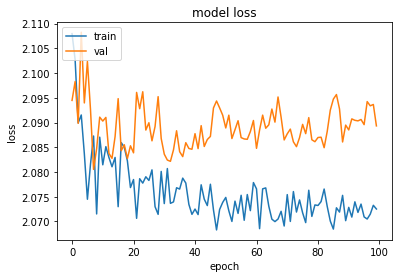

>#2: 9.901


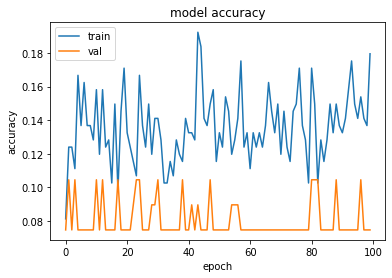

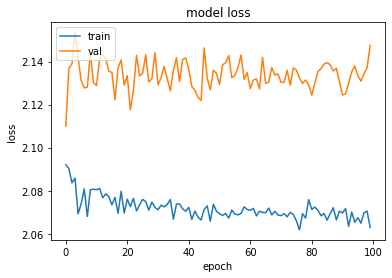

>#3: 12.871


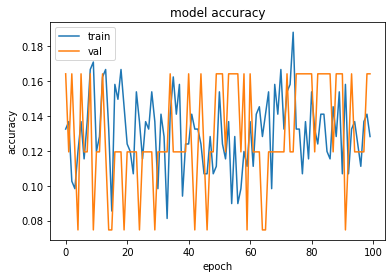

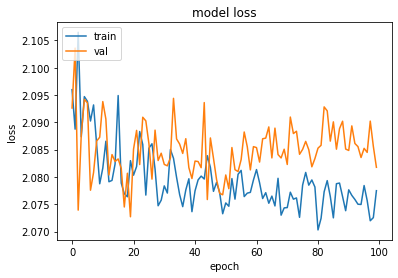

>#4: 7.921


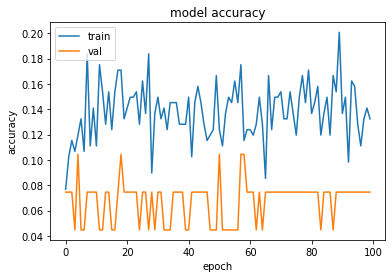

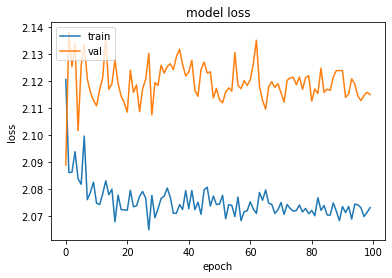

>#5: 12.871
Scores:  [8.9108906686306, 9.90099012851715, 12.871286273002625, 7.920791953802109, 12.871286273002625]


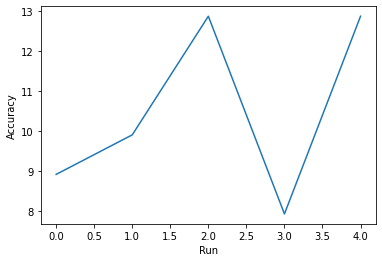

Accuracy: 10.495% (+/-2.039)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [16]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.3,0.3,0.3,0.3)),nLSTMunits=(100,100))
  print("-------------------------------------------")

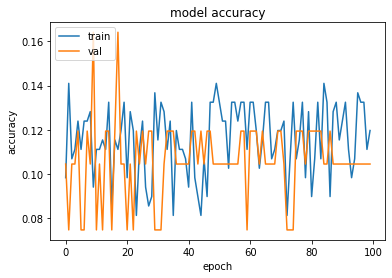

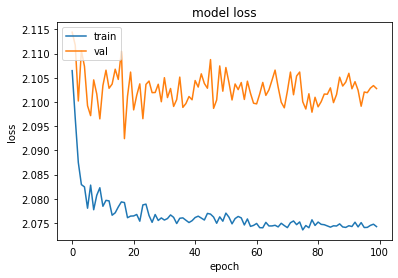

>#1: 13.861


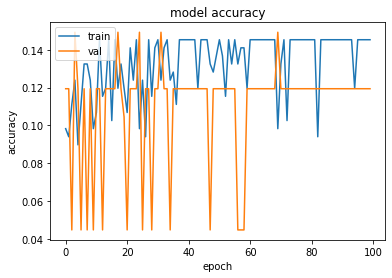

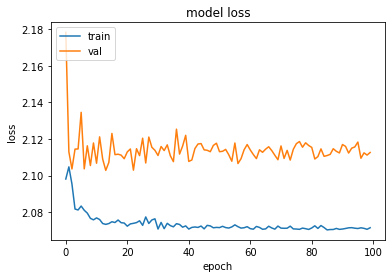

>#2: 9.901


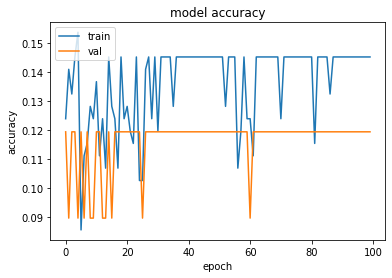

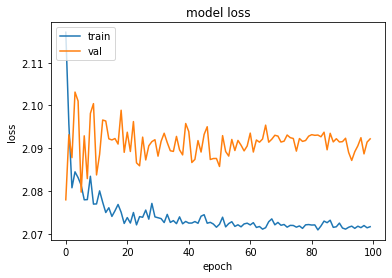

>#3: 7.921


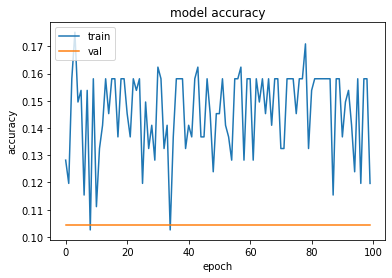

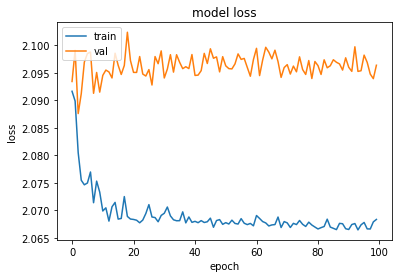

>#4: 5.941


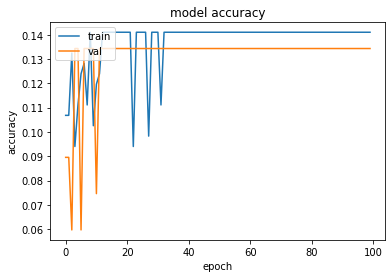

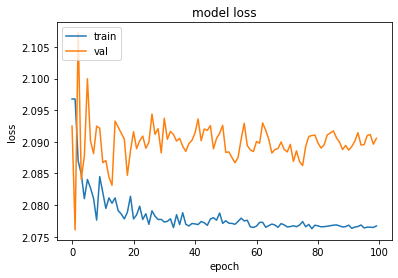

>#5: 9.901
Scores:  [13.861386477947235, 9.90099012851715, 7.920791953802109, 5.940593779087067, 9.90099012851715]


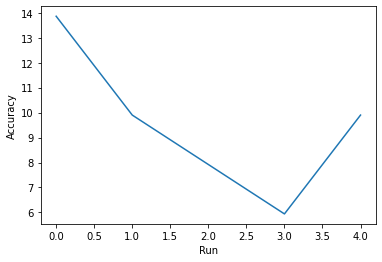

Accuracy: 9.505% (+/-2.627)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [17]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.0,0.0,0.0,0.0)),nLSTMunits=(100,100))
  print("-------------------------------------------")

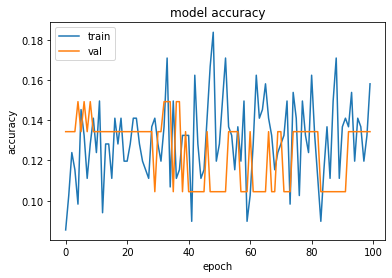

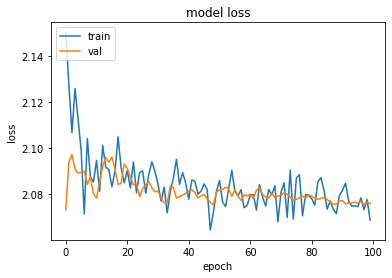

>#1: 9.901


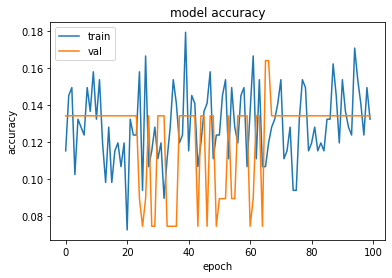

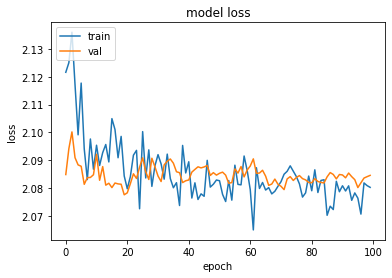

>#2: 11.881


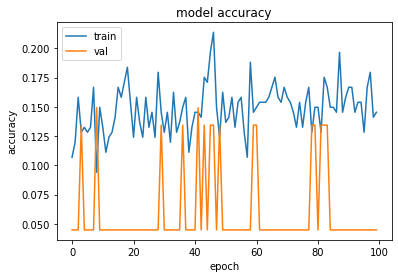

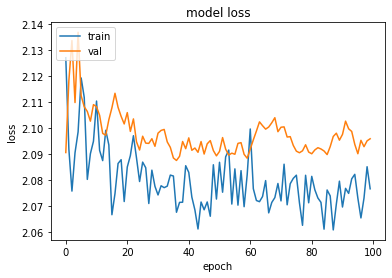

>#3: 11.881


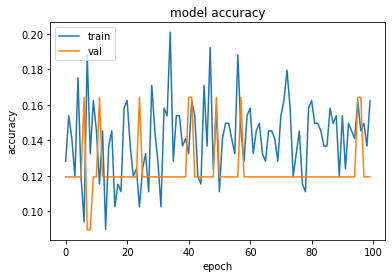

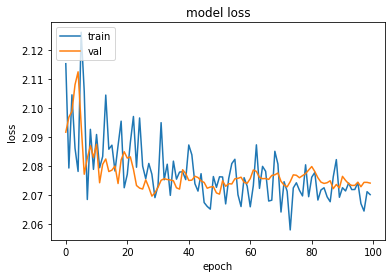

>#4: 8.911


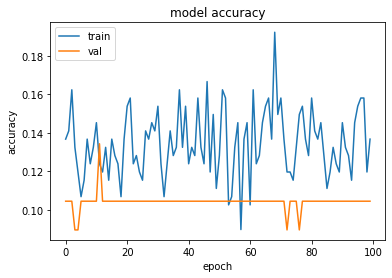

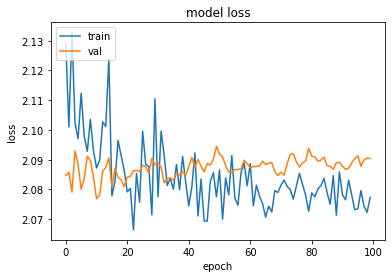

>#5: 10.891
Scores:  [9.90099012851715, 11.881187558174133, 11.881187558174133, 8.9108906686306, 10.891088843345642]


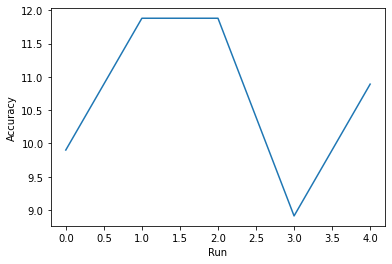

Accuracy: 10.693% (+/-1.155)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [18]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.7,0.7,0.7,0.7)),nLSTMunits=(100,100))
  print("-------------------------------------------")

The above curves also look good

In [ ]:
#OBSERVATION-> REDUCING DROPOUT HAS HELPED WITH THE ZIG ZAG NATURE OF THE CURVES

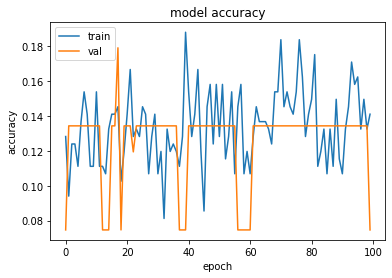

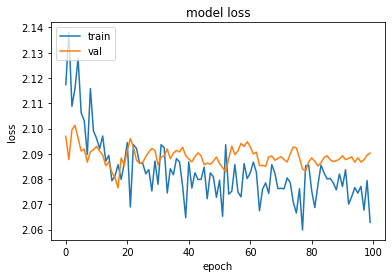

>#1: 13.861


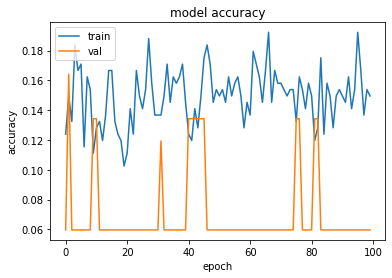

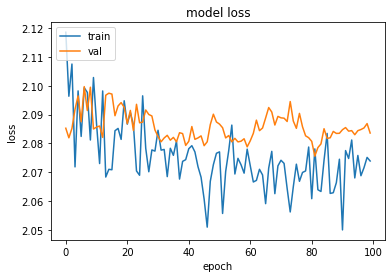

>#2: 9.901


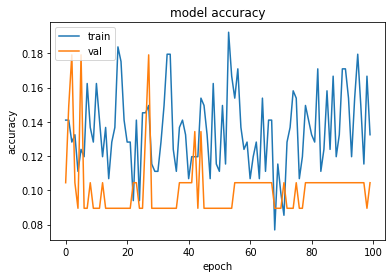

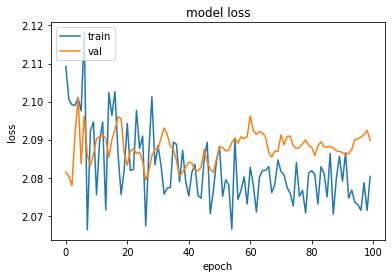

>#3: 10.891


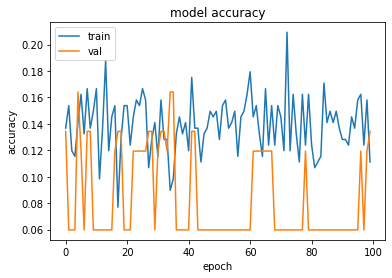

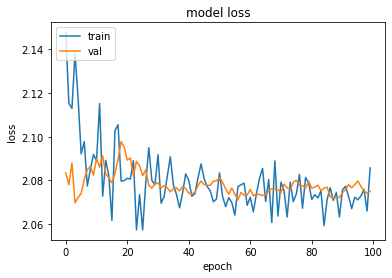

>#4: 7.921


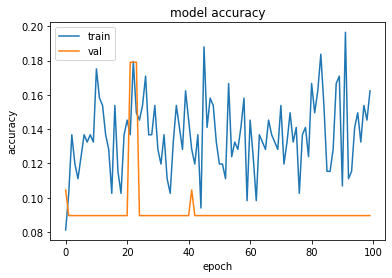

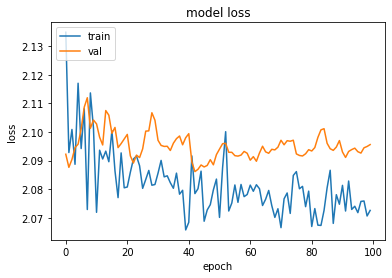

>#5: 12.871
Scores:  [13.861386477947235, 9.90099012851715, 10.891088843345642, 7.920791953802109, 12.871286273002625]


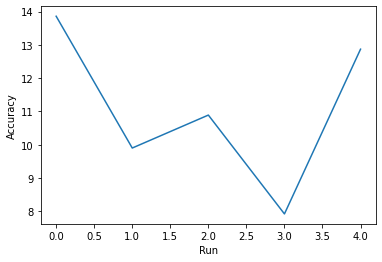

Accuracy: 11.089% (+/-2.114)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [19]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.1,0.2,0.7,0.7)),nLSTMunits=(100,100))
  print("-------------------------------------------")

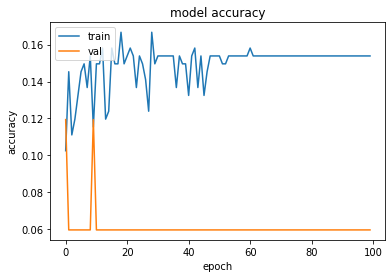

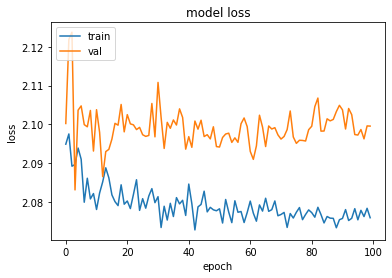

>#1: 11.881


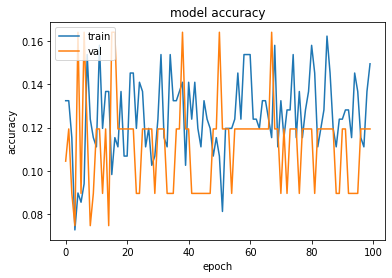

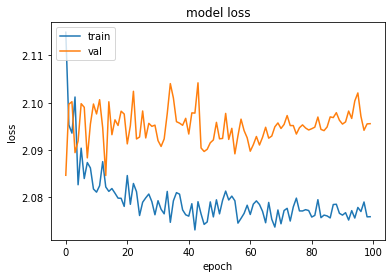

>#2: 11.881


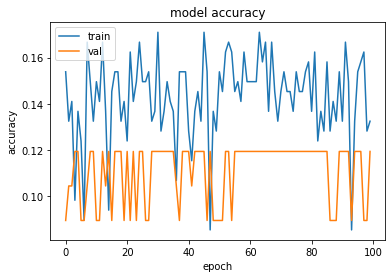

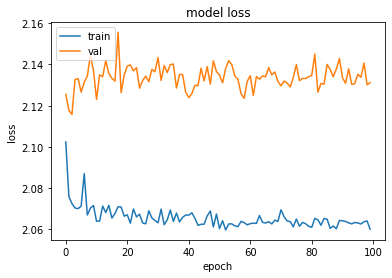

>#3: 8.911


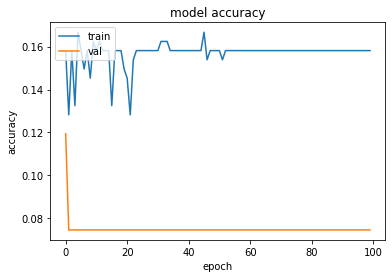

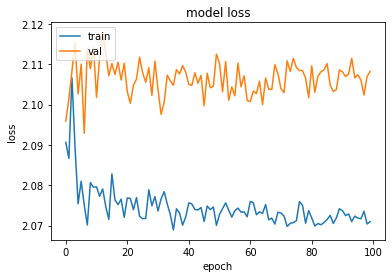

>#4: 9.901


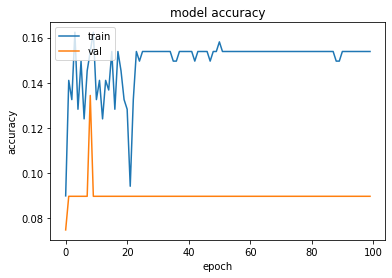

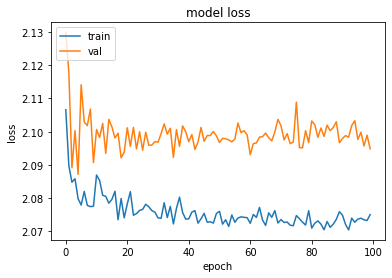

>#5: 9.901
Scores:  [11.881187558174133, 11.881187558174133, 8.9108906686306, 9.90099012851715, 9.90099012851715]


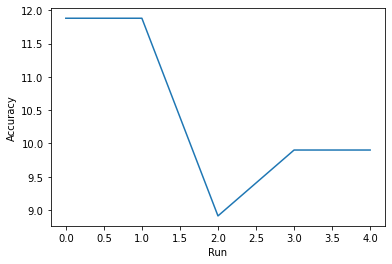

Accuracy: 10.495% (+/-1.188)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [20]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.7,0.7,0.1,0.2)),nLSTMunits=(100,100))
  print("-------------------------------------------")

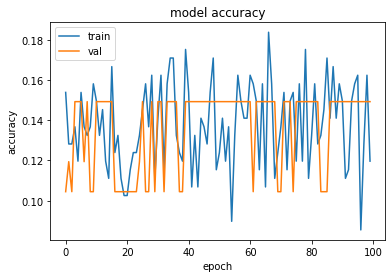

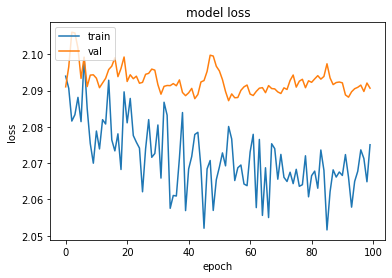

>#1: 9.901


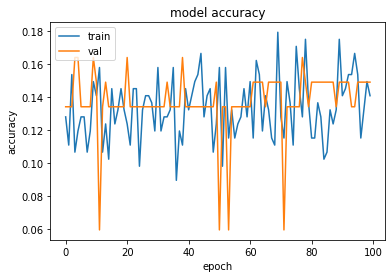

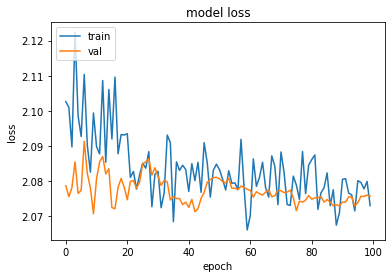

>#2: 8.911


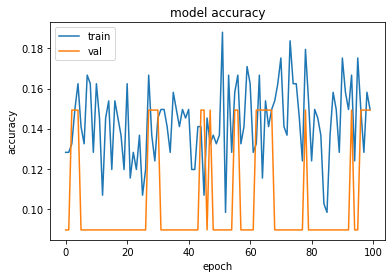

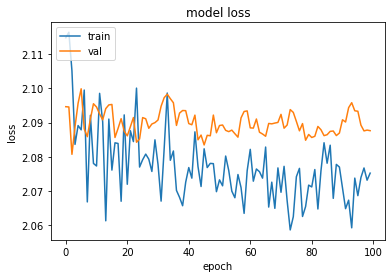

>#3: 7.921


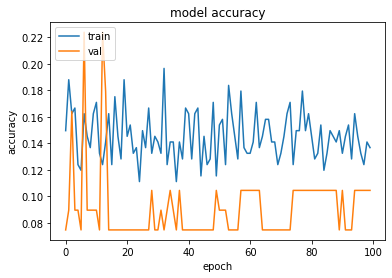

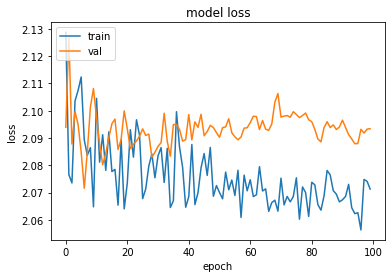

>#4: 8.911


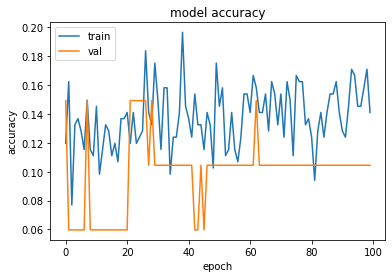

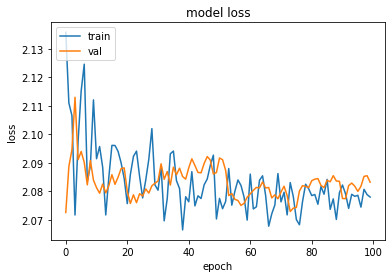

>#5: 9.901
Scores:  [9.90099012851715, 8.9108906686306, 7.920791953802109, 8.9108906686306, 9.90099012851715]


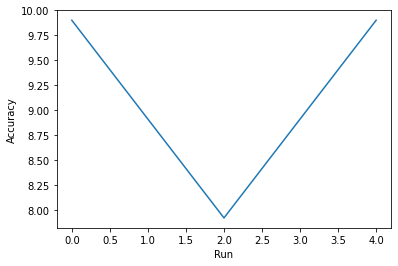

Accuracy: 9.109% (+/-0.741)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [21]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.4,0.4,0.7,0.7)),nLSTMunits=(100,100))
  print("-------------------------------------------")

In [ ]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.4,0.4,0.7,0.7)),nLSTMunits=(100,100))
  print("-------------------------------------------")